Here, I will calculate LD using plink with a command given by Victor for best consistency across projects.

Then, I create 10 kB windows across the genome for the overall distribution, and get the mean values of LD there. I will do the same for each TRD region and then these can be compared as I did with the other genomic signals.

In [2]:
library(data.table)
library(tidytable)
library(ggplot2)
source("~/BrusselSprouts/scripts/functions.R")

Warning message:
"package 'data.table' was built under R version 4.1.3"
Warning message:
"package 'tidytable' was built under R version 4.1.3"

Attaching package: 'tidytable'


The following objects are masked from 'package:data.table':

    between, first, fread, last


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%


Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:tidytable':

    across, add_count, add_tally, anti_join, arrange, between,
    bind_cols, bind_rows, c_across, case_match, case_when, coalesce,
    consecutive_id, count, cross_join, cume_dist, cur_column, cur_data,
    cur_group_id, cur_group_rows, dense_rank, desc, distinct, filter,
    first, full_join, group_by, group_cols, group_split, group_vars,
    if_all, if_an

In [122]:
output_dir<-"/home/jnrunge/data/trd/LD_data"
if(!dir.exists(output_dir)){
    dir.create(output_dir)
}

In [5]:
if(!file.exists(LD_file<-"/home/jnrunge/data/trd/full2489Matrix.vcf.gz.plink.LD.txt.ld.gz")){
    vcf_file <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
    cmd<-paste0("cd ",dirname(vcf_file), " && plink --vcf ",vcf_file," --r2 --ld-window-kb 10 --ld-window-r2 0 -out ",basename(vcf_file),".plink.LD.txt -aec && gzip -f full2489Matrix.vcf.gz.plink.LD.txt.ld")
    print(cmd)
    stop("Run command")
}

In [6]:
LD_data<-fread(LD_file)
head(LD_data)

CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>
chromosome1,6,.,chromosome1,19,.,8.74040e-07
chromosome1,6,.,chromosome1,20,.,8.75448e-07
chromosome1,6,.,chromosome1,22,.,3.53216e-06
chromosome1,6,.,chromosome1,24,.,6.21494e-06
chromosome1,6,.,chromosome1,25,.,1.15553e-05
chromosome1,6,.,chromosome1,26,.,1.58041e-05


In [13]:
getMeanWindowLD<-function(x){
    LD_data_windows_slice<-slice(LD_data_windows, x)
    LD_values<-filter(LD_data, CHR_A==CHR_B, CHR_A==pull(LD_data_windows_slice, chrom),
                      BP_A>=pull(LD_data_windows_slice, from), BP_A<=pull(LD_data_windows_slice, to))
    return(mean(pull(LD_values, R2),na.rm=TRUE))
}

In [ ]:
# get windows from this
if(!file.exists("02_LD_LD_data_windows.RData")){
    window_size<-10000

    LD_data_windows<-data.table()

    for(chr in unique(pull(LD_data, CHR_A))){
        from<-filter(LD_data,CHR_A==chr)%>%pull(BP_A)
        to<-max(from)
        from<-min(from)

        windows<-round(seq(from=from, to=to, length.out = round((to-from)/window_size)))
        head(windows)

        LD_data_windows<-bind_rows(LD_data_windows,data.table(chrom=chr, from=windows[-length(windows)], to=windows[-1]))
        }

    LD_data_windows<-mutate(LD_data_windows, mean_LD=unlist(lapply(1:nrow(LD_data_windows), getMeanWindowLD)))
    head(LD_data_windows)
    tail(LD_data_windows)
    saveRDS(LD_data_windows, "02_LD_LD_data_windows.RData")
}else{
    readRDS("02_LD_LD_data_windows.RData")
}


In [24]:
head(LD_data_windows)
tail(LD_data_windows)

chrom,from,to,mean_LD
<chr>,<dbl>,<dbl>,<dbl>
chromosome1,6,10470,0.05689725
chromosome1,10470,20934,0.10575211
chromosome1,20934,31398,0.12074254
chromosome1,31398,41862,0.06613197
chromosome1,41862,52326,0.04086678
chromosome1,52326,62790,0.03635872


chrom,from,to,mean_LD
<chr>,<dbl>,<dbl>,<dbl>
chromosome16,887254,897387,0.01308613
chromosome16,897387,907519,0.01168858
chromosome16,907519,917652,0.01667207
chromosome16,917652,927784,0.03277663
chromosome16,927784,937917,0.07048050
chromosome16,937917,948049,0.10126770


In [27]:
# load all TRD regions
TRD_regions<-fread_and_bind_files(list.files("/home/jnrunge/data/TRD/results/shiny/",pattern="TRD_regions.csv.gz$",full.names = TRUE))
TRD_regions<-mutate(TRD_regions, file=basename(file))%>%separate(file, c("cross","discard"), "-")%>%select(-discard)%>%filter(chr_start==chr_end)%>%
rename(chr=chr_start)%>%select(-chr_end)
# translate global positions to chr positions

for(c in select(TRD_regions,cross)%>%distinct()%>%pull())
    {
    AF<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    tmp_TRD_regions<-filter(TRD_regions, cross==c)%>%select(-any_of("start"))%>%
              left_join(select(AF, chr,pos,global_pos)%>%
              rename(global_start=global_pos), by=c("chr","global_start"))%>%rename(start=pos)
    
    TRD_regions<-filter(TRD_regions, cross!=c)%>%bind_rows(tmp_TRD_regions)
}

TRD_regions<-mutate(TRD_regions, end=global_end-(global_start-start))

head(TRD_regions)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250


In [70]:
head(log(pull(LD_data_windows,mean_LD)))

[1] -2.866508 -2.246657 -2.114095 -2.716103 -3.197438 -3.314321

In [78]:
(-2.86650833420531-(-3.52))/0.788


[1] 0.8293041

In [97]:
scaled_ld<-scale(log(pull(LD_data_windows,mean_LD)))

In [90]:
library(mixtools)
LD_dist <- normalmixEM(as.numeric(scale(log(pull(LD_data_windows,mean_LD)))), lambda = .5, mu = c(-1, 1), sigma = c(1,1))

number of iterations= 73 


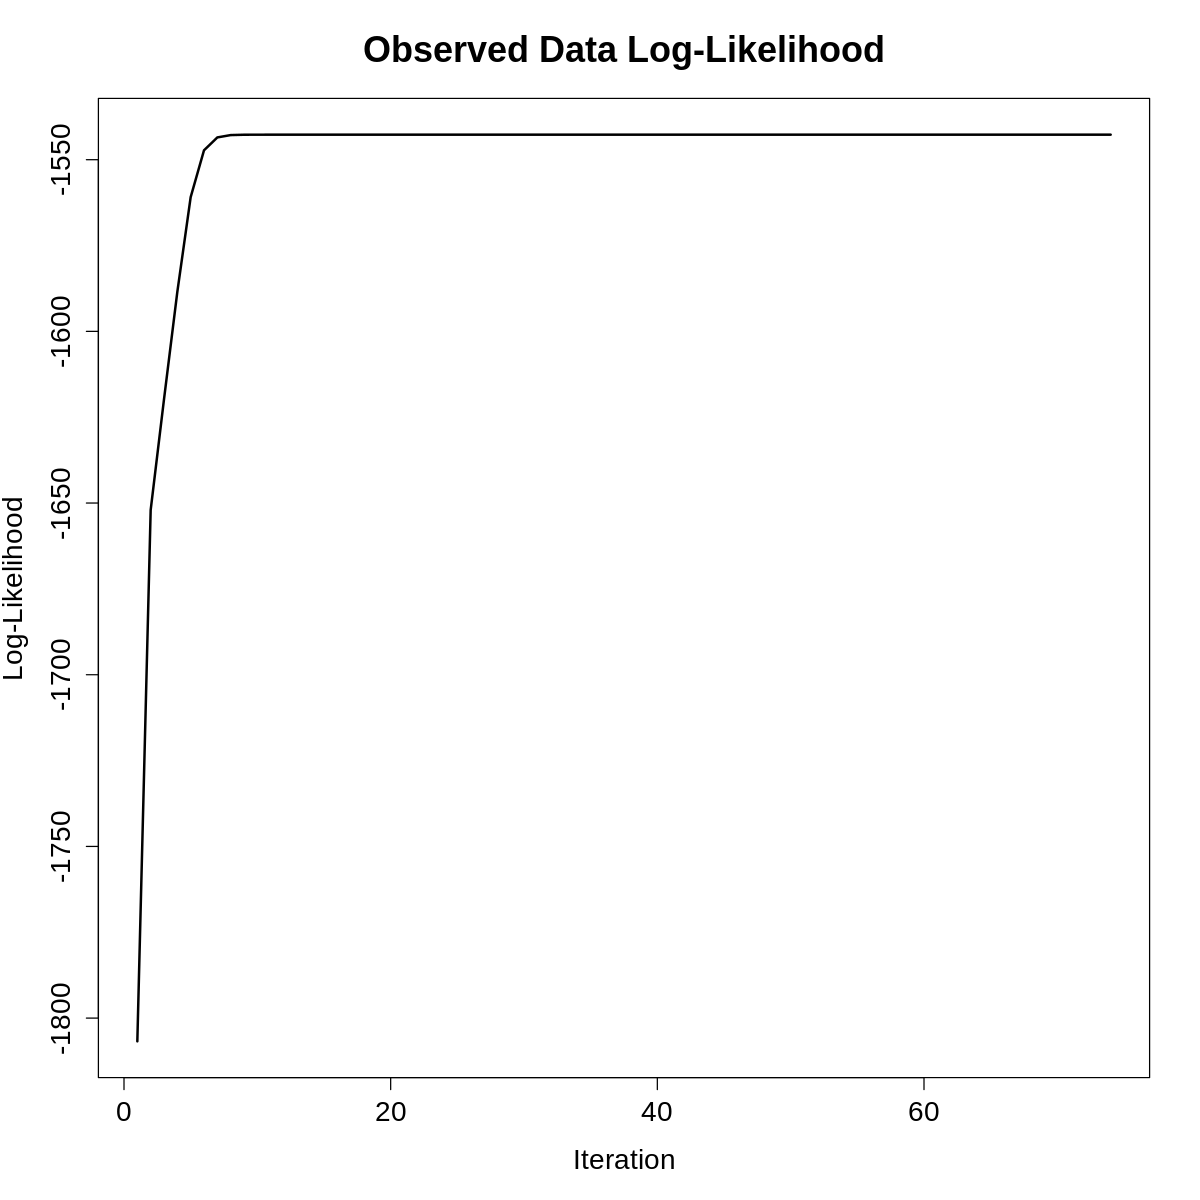

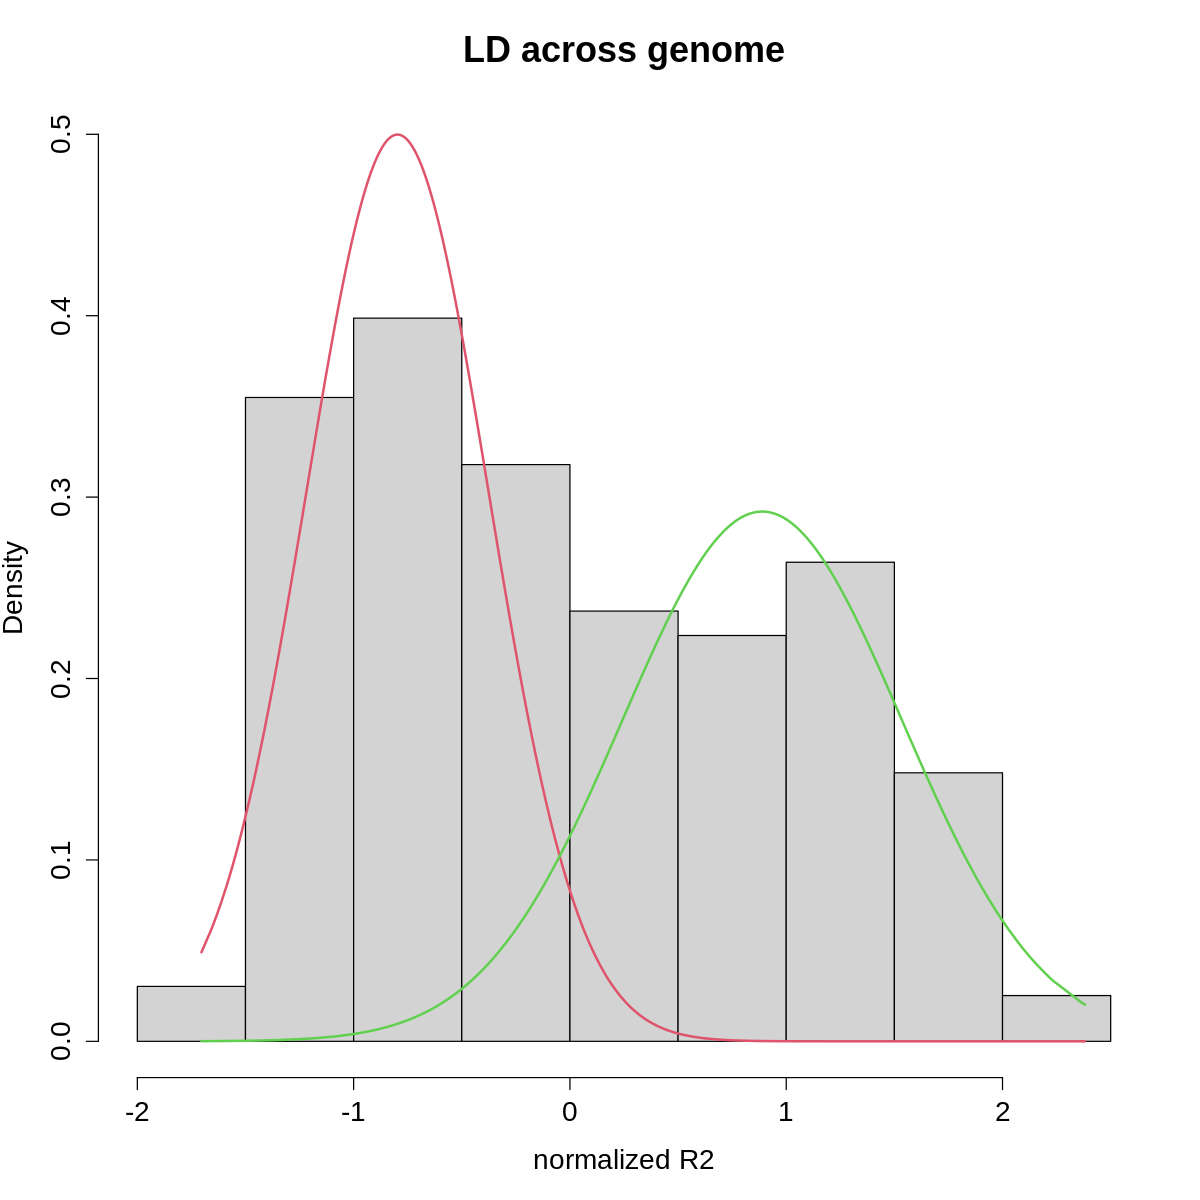

In [91]:
plot(LD_dist, density=TRUE, cex.axis=1.4, cex.lab=1.4, cex.main=1.8,
      main2="LD across genome", xlab2="normalized R2")

In [93]:
LD_dist$mu
LD_dist$sigma

[1] -0.7971675  0.8888918

[1] 0.4207775 0.6458586

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


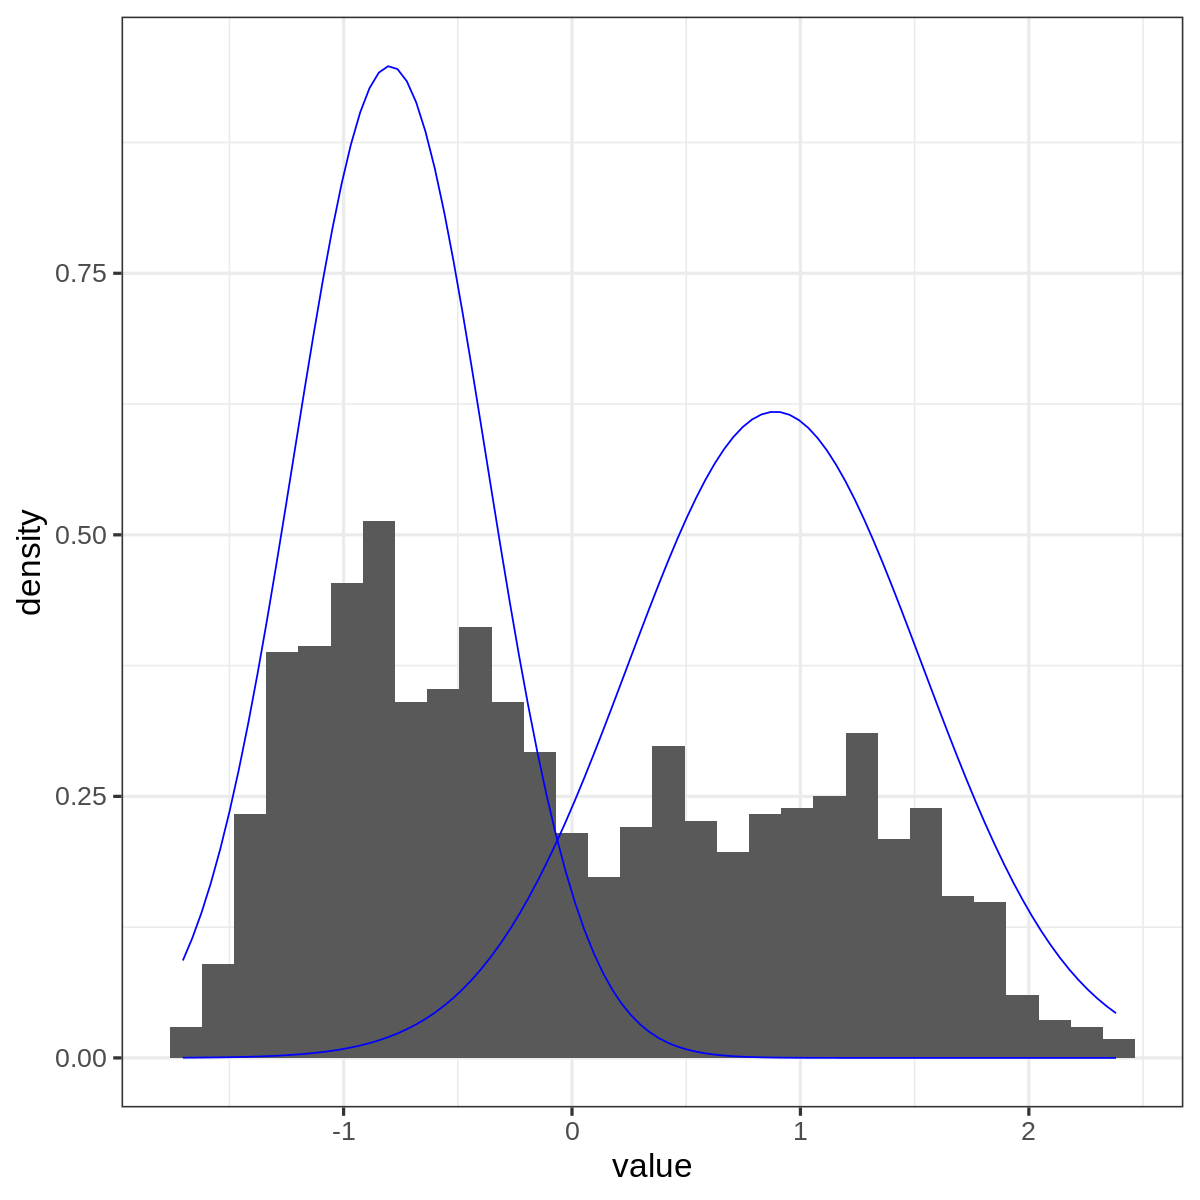

In [102]:
values<-as.numeric(scaled_ld)
median_dist<-median(values)

default_ggplot<-ggplot(data.table(value=values), mapping=aes(x=value))+
geom_histogram(aes(y = after_stat(density)))+
stat_function(
        fun = dnorm, 
        args = list(mean = LD_dist$mu[1], sd = LD_dist$sigma[1]), 
        color = "blue"
      )+
stat_function(
        fun = dnorm, 
        args = list(mean = LD_dist$mu[2], sd = LD_dist$sigma[2]), 
        color = "blue"
      )+theme_bw(20)
default_ggplot

In [109]:
str(scaled_ld)

 num [1:1189, 1] 0.832 1.619 1.787 1.023 0.413 ...
 - attr(*, "scaled:center")= num -3.52
 - attr(*, "scaled:scale")= num 0.788


In [111]:
transform_LD<-function(x){
    x<-log(x)
    x<-x-attr(scaled_ld, "scaled:center")
    x<-x/attr(scaled_ld, "scaled:scale")
}

In [113]:
getSDmultiplier<-function(x, mean, sd){
    return((x - mean) / sd)
}

In [123]:
TRD_regions<-mutate(TRD_regions, LD_sd_multi_1=NA, LD_sd_multi_2=NA)
for(i in 1:nrow(TRD_regions)){
    TRD_regions_slice<-slice(TRD_regions,i)
    LD_values<-filter(LD_data, CHR_A==CHR_B, CHR_A==pull(TRD_regions_slice, chr),
                          BP_A>=pull(TRD_regions_slice, start), BP_A<=pull(TRD_regions_slice, end))
    LD_value<-mean(pull(LD_values, R2),na.rm=TRUE)
    LD_value<-transform_LD(LD_value)
    saveRDS(default_ggplot+geom_vline(xintercept=LD_value, color="red"), paste0(output_dir,"/",pull(TRD_regions_slice, cross),".",pull(TRD_regions_slice, ID),".",
                     "LD_plot",".RDS"))
    TRD_regions<-mutate(TRD_regions,
                       LD_sd_multi_1=ifelse(row_number()==i,
                       getSDmultiplier(LD_value, LD_dist$mu[1], LD_dist$sigma[1]),LD_sd_multi_1),
                        LD_sd_multi_2=ifelse(row_number()==i,
                       getSDmultiplier(LD_value, LD_dist$mu[2], LD_dist$sigma[2]),LD_sd_multi_2))
    }

In [125]:
head(TRD_regions)
fwrite(select(TRD_regions, cross, ID, LD_sd_multi_1, LD_sd_multi_2), paste0(output_dir,"/","LD_plot_data",".csv.gz"))

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,LD_sd_multi_1,LD_sd_multi_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,1.645598,-1.5384617
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,2.811843,-0.7786518
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,2.145490,-1.2127813
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,1.342113,-1.7361824
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,2.606669,-0.9123228
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,1.644424,-1.5392264
